Student Name: Akshata Bheemasamudra Mallikarjunappa

Student ID: 23164204

# Activity 6: Pytorch and CNNs for Fashion-MNIST

In this activity, we are going to explore designing various neural networks for the FashionMNIST classification problem. This is, of course, a 'toy' problem, but the fundamentals of classification of images is here.


## Hints, tips, and notes

* Here I'm not going to mandate TensorBoard. In Colab, this is a little bit more involved. Instead, we'll just put the losses and accuracies in a list and print them after training. However, TensorBoard is very useful, particularly for projects, so I suggest playing around with it.
* Some of these runs will take several minutes to complete. This is the nature of ML. Grab a beer, or a coffee.

As usual, we will give you some code that you use to build the rest of the activity.

# Common Code

All the imports

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from torchvision import models
import torchvision

### 1. Select the device to use.

To access the GPU on Google Colab, `Select Runtime` -> `Change Runtime Type` and pick `GPU` from the `Hardware Accelerator` dropdown menu. In the free version, the GPU is modest. If you buy credits, you get access to a much nice A100 GPU. In both cases, you may find contention for the resource is an issue, but less likely to happen if you use credits.

In [2]:
# Get appropriate device for training
device = ( "cuda"     # CUDA is a programming interface for certain Nvidia GPUs
           if torch.cuda.is_available()
           else "mps"  # Kind of like CUDA for a mac, I guess? I don't use macs
           if torch.backends.mps.is_available()
           else "cpu" )   # If you end up with CPU, go use Google Colab and get a GPU

print(f"{device} device available")

cuda device available


### 2. Code for training the models

I'm going to provide this code, rather than you having to struggle creating it. This is a normal training cycle with PyTorch. However, I do want you to explain the PyTorch functions called in the train function. I will marke them with comments.

In [3]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()        #<--- what is this function for?

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)   #<--- this is a bit funny, explain it

        # Compute prediction error
        pred = model(X)                     #<--- what is this for?
        loss = loss_fn(pred, y)             #<--- what is this for?

        # This is the backprop set up. Explain what each of the steps do
        loss.backward()                     #<--- what is this for?
        optimizer.step()                    #<--- what is this for?
        optimizer.zero_grad()               #<--- what is this for?

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in range(epochs):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimizer)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy



### <font color='red'>Your input here.</font>
<font color='red'>Enter you description of the above parts:</font>

**model.train()** - to train the model by setting it in training mode.

**X, y = X.to(device), y.to(device)** - to ensure that model parameters are stored in the right device, for example GPU or CPU. therefore, X which is input and y which is labels is moved to the specified device.

**pred = model(X)** - Letting the model know to make predictions(give output) on the input data X.

**loss = loss_fn(pred, y)** - loss_fn calculates the difference between the predicted value and expected value and assigns to variable loss. The lower the loss value the better the model is performing (predicting correctly).

**loss.backward()** - Computing the backward gradients of the loss function over the learning weights with the backward call, that is, performing backpropagation to decrease the loss.

**optimizer.step()** - optimizer to take a step adjusting the learning weights based on the gradients computed using loss.backward to reduce the loss.

**optimizer.zero_grad()** - This clears the gradients that is stored from the previous batch and sets it to zero in order to use the gradients from current batch.


### 3. Load the data

1. Load the Fashion-MNIST dataset using `torchvision`'s `datasets` library (e.g., [`datasets.FashionMNIST...`](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html)...)
2. When loading the data, convert it to tensor format ([`transforms.ToTensor`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html)), and apply the standard scaler to the data (using [`transforms.Normalize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)). Use the [`transforms.Resize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Resize.html) transform to turn it into a 28x28 image rather than a 784-vector
    * Rather than loading the data, and caluclating the mean and std, you can use the values `mean = 0.2859` and `std = 0.3530`. I pre-calculated these for you!
3. Create the [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)s. Here we're going to use a batch size of 64.
4. Display a few examples of the dataset - this is always a good idea to make sure the data has loaded correctly

We haven't really touched on batch size yet, because up to now we have used plain old gradient descent. Later on, we will use the Adam optimiser, because it is quicker and uses less memory. But Adam is a mini-batch optimizer, and you have to pick that mini-batch size. Bit more info on this, if you are interested:
 * https://sebastianraschka.com/faq/docs/gradient-optimization.html
 * https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

We need to set the batch size when we create the dataloaders.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [4]:
transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor(), transforms.Normalize((0.2859,), (0.3530,))])

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

testing_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)



100%|██████████| 26421880/26421880 [00:03<00:00, 8768474.98it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 132117.91it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2501638.43it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6486115.05it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [5]:
batch_size = 64
training_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
testing_loader = torch.utils.data.DataLoader(testing_data, batch_size=batch_size, shuffle=False)

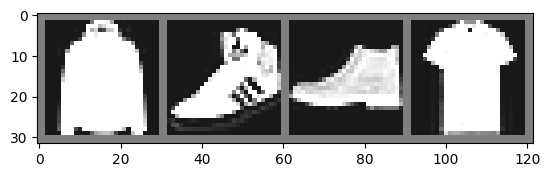

Labels: [4 7 9 0]


In [6]:
import torchvision
import numpy
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(numpy.transpose(npimg, (1, 2, 0)))
    plt.show()

# printing random training images
dataiter = iter(training_loader)
images, labels = next(dataiter)

# display images
imshow(torchvision.utils.make_grid(images[:4]))

# Print labels
print('Labels:', labels[:4].numpy())


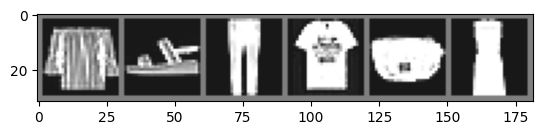

Labels: [6 5 1 0 8 3]


In [7]:
imshow(torchvision.utils.make_grid(images[9:15]))
print('Labels:', labels[9:15].numpy())


---
## 1. Replicate the Neural Network from the previous tasks for the FashionMNIST dataset
---


In the previous activity, you designed a fully connected neural network (a multi-layer perceptron) to predict on Fashion-MNIST.

1. Replicate the best network that you found in that activity, but in PyTorch.
1. Use [`summary`](https://pypi.org/project/torch-summary/) to display a summary of your model.
1. Use some random inputs to test the model. This will be meaningless, as the model is not trained yet (and the inputs are random). However, it is useful to test that you have defined the model at leats without any coding errors.

Hints and notes:
 * We need to [`Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) the incoming data. In the previous step, you loaded the dataset as a 28x28 image (because, later on we will be using CNNs that require image inputs). However, fully connected layers require vector inputs. `nn.Flatten` converts the image input to a vector (i.e., a 28x28 image to a 784 vector).
 * Use [`.to(device)`](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html) to "send" objects to the GPU (if you have one). E.g., once you define your class for the neural network, you will create an instance of that NN - you need to send this object to the GPU.
 * Generally, at inference time, we will use a [`softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) on the output of the model. Prior to the softmax, the model outputs a score per class. That is, there will be 10 outputs. However, here we will ignore the softmax part.


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [8]:
import torch.nn.functional as F
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
      super(NeuralNetwork, self).__init__()
      self.flatting = nn.Flatten()
      self.fc1 = nn.Linear(28 * 28, 100)
      self.fc2 = nn.Linear(100, 50)
      self.fc3 = nn.Linear(50, 20)


    def forward(self, x):
        x = self.flatting(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = NeuralNetwork()



summary(model.to(device), (1,28*28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
            Linear-3                   [-1, 50]           5,050
            Linear-4                   [-1, 20]           1,020
Total params: 84,570
Trainable params: 84,570
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.32
Estimated Total Size (MB): 0.33
----------------------------------------------------------------


In [ ]:
# generating random input data
random_input = torch.randn(1, 1, 28, 28).to(device)
print(model(random_input))

dataiter = iter(training_loader)
images, labels = next(dataiter)
print(model(images[0].to(device)))

tensor([[ 0.2168, -0.0786, -0.2742,  0.3629,  0.0924,  0.4295, -0.3201, -0.2339,
          0.0858, -0.2341]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.0710, -0.2184, -0.1030,  0.2704,  0.0063,  0.2326, -0.0622, -0.0960,
          0.1925, -0.1301]], device='cuda:0', grad_fn=<AddmmBackward0>)


Now train the model.

We will use [Cross Entropy Loss](https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e), and as discussed, the Adam optimiser (with learning rate = 0.001).

* Call the training loop - I would suggest a max of ~20 epochs
* Use matplotlib to plot the train and test loss, and the train and test accuracy
* Describe what you see in the graphs

This training could take a few minutes. But note how you will see a bunch of losses reported in each epoch? These are the mini-batches in Adam that we discussed before. Then there will be an overall Train and Test error reported for the Epoch.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [ ]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Note, replace model with the instance name of your model



train_loss, train_accuracy, test_loss, test_accuracy = train_loop(training_loader, testing_loader, model, loss_fn, optimizer, 20)

Epoch 1:

loss: 2.310423  [   64/60000]
loss: 0.523165  [ 6464/60000]
loss: 0.459847  [12864/60000]
loss: 0.539399  [19264/60000]
loss: 0.606389  [25664/60000]
loss: 0.298445  [32064/60000]
loss: 0.260005  [38464/60000]
loss: 0.420251  [44864/60000]
loss: 0.259036  [51264/60000]
loss: 0.434459  [57664/60000]
Train Error: 
 Accuracy: 84.3%, Avg loss: 0.420978 

Test Error: 
 Accuracy: 82.8%, Avg loss: 0.462933 

Epoch 2:

loss: 0.412290  [   64/60000]
loss: 0.282651  [ 6464/60000]
loss: 0.260423  [12864/60000]
loss: 0.359127  [19264/60000]
loss: 0.348679  [25664/60000]
loss: 0.456677  [32064/60000]
loss: 0.388862  [38464/60000]
loss: 0.413632  [44864/60000]
loss: 0.465413  [51264/60000]
loss: 0.397715  [57664/60000]
Train Error: 
 Accuracy: 88.4%, Avg loss: 0.315492 

Test Error: 
 Accuracy: 86.8%, Avg loss: 0.364662 

Epoch 3:

loss: 0.487790  [   64/60000]
loss: 0.353987  [ 6464/60000]
loss: 0.222034  [12864/60000]
loss: 0.347638  [19264/60000]
loss: 0.315903  [25664/60000]
loss: 0.37

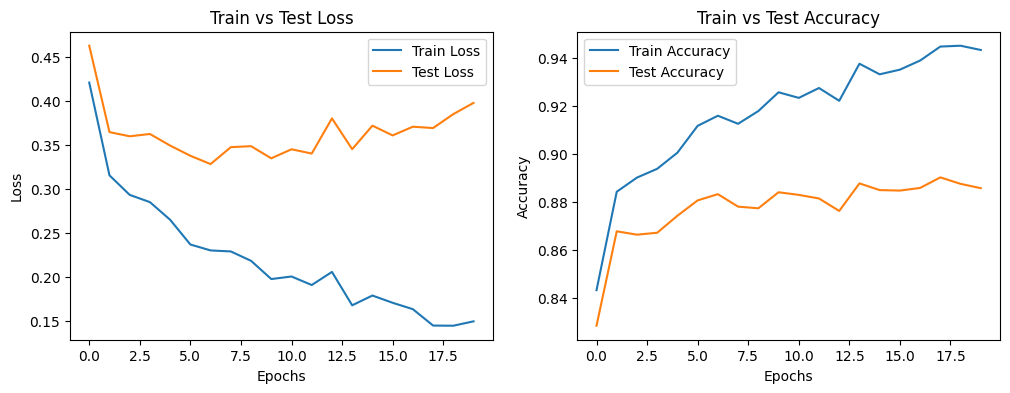

In [ ]:


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(20), train_loss, label='Train Loss')
plt.plot(range(20), test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(20), train_accuracy, label='Train Accuracy')
plt.plot(range(20), test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.legend()

plt.show()

In [ ]:
epochs = 20  # Number of epochs

train_loss, train_accuracy, test_loss, test_accuracy = train_loop(
    train_loader, test_loader, model, loss_fn, optimizer, epochs
)

Epoch 1:

loss: 2.318360  [   64/60000]
loss: 0.717220  [ 6464/60000]
loss: 0.450567  [12864/60000]
loss: 0.307400  [19264/60000]
loss: 0.296479  [25664/60000]
loss: 0.360072  [32064/60000]
loss: 0.527103  [38464/60000]
loss: 0.566061  [44864/60000]
loss: 0.488433  [51264/60000]
loss: 0.436967  [57664/60000]
Train Error: 
 Accuracy: 87.0%, Avg loss: 0.351471 

Test Error: 
 Accuracy: 85.4%, Avg loss: 0.398078 

Epoch 2:

loss: 0.226975  [   64/60000]
loss: 0.441959  [ 6464/60000]
loss: 0.244025  [12864/60000]
loss: 0.256469  [19264/60000]
loss: 0.338829  [25664/60000]
loss: 0.360709  [32064/60000]
loss: 0.348499  [38464/60000]
loss: 0.284662  [44864/60000]
loss: 0.227686  [51264/60000]
loss: 0.247858  [57664/60000]
Train Error: 
 Accuracy: 88.2%, Avg loss: 0.314204 

Test Error: 
 Accuracy: 85.9%, Avg loss: 0.384715 

Epoch 3:

loss: 0.236550  [   64/60000]
loss: 0.407199  [ 6464/60000]
loss: 0.412954  [12864/60000]
loss: 0.347994  [19264/60000]
loss: 0.382898  [25664/60000]
loss: 0.21

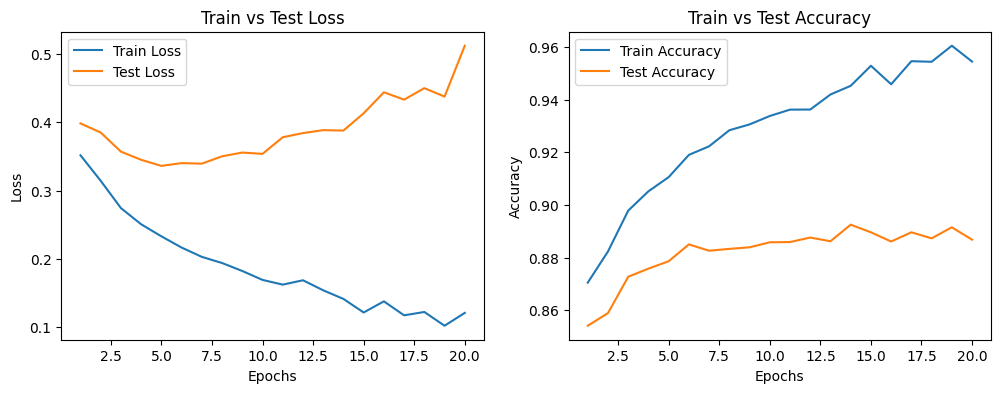

In [ ]:


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_loss, label='Train Loss')
plt.plot(range(1, epochs+1), test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.legend()

plt.show()


---

# 2. Replicate LeNet-5 for Fashion-MNIST

---


Below is the LeNet architecture (from https://en.wikipedia.org/wiki/LeNet). If you search on the internet, you will find slightly different implementations and descriptions of LeNet-5, but below is what was actually in LeCun's [original paper](https://ieeexplore.ieee.org/document/726791). Of course, LeCun was applying this to the digit recognition problem (MNIST), but we are looking at Fashion-MNIST.

 * Create the model in PyTorch.
 * Train the model using the same parameters as above, and plot the loss and accuracy.
 * Discuss and compare (in a markdown cell) with the fully connected model above. Particularly consider - number of parameters, performance, and overfitting?

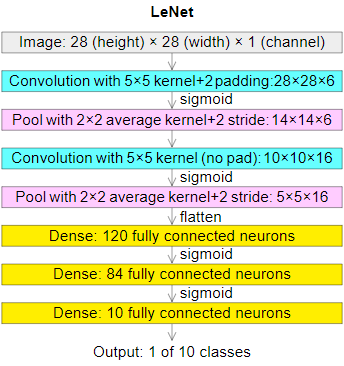

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [ ]:
##############################
# Your code below

class LeNet(nn.Module):
    def __init__(self):

        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 5,padding=2)
        self.pool = nn.AvgPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.sigmoid(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.sigmoid(x)
        x = self.pool(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        return x


LeNetwork = LeNet().to(device)
summary(LeNetwork, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         AvgPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         AvgPool2d-4             [-1, 16, 5, 5]               0
           Flatten-5                  [-1, 400]               0
            Linear-6                  [-1, 120]          48,120
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


In [ ]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(LeNetwork.parameters(), lr=1e-3)
# Note, replace model with the instance name of your model



LeNet_train_loss, LeNet_train_accuracy, LeNet_test_loss, LeNet_test_accuracy = train_loop(training_loader, testing_loader, LeNetwork, loss_fn, optimizer, 20)

Epoch 1:

loss: 2.319039  [   64/60000]
loss: 1.946041  [ 6464/60000]
loss: 1.254963  [12864/60000]
loss: 1.035586  [19264/60000]
loss: 0.917491  [25664/60000]
loss: 0.792750  [32064/60000]
loss: 0.720416  [38464/60000]
loss: 0.577438  [44864/60000]
loss: 0.590062  [51264/60000]
loss: 0.621237  [57664/60000]
Train Error: 
 Accuracy: 74.5%, Avg loss: 0.657312 

Test Error: 
 Accuracy: 74.0%, Avg loss: 0.674738 

Epoch 2:

loss: 0.693266  [   64/60000]
loss: 0.716878  [ 6464/60000]
loss: 0.700197  [12864/60000]
loss: 0.550473  [19264/60000]
loss: 0.535663  [25664/60000]
loss: 0.439752  [32064/60000]
loss: 0.508842  [38464/60000]
loss: 0.559742  [44864/60000]
loss: 0.515172  [51264/60000]
loss: 0.639940  [57664/60000]
Train Error: 
 Accuracy: 78.7%, Avg loss: 0.540082 

Test Error: 
 Accuracy: 77.8%, Avg loss: 0.562624 

Epoch 3:

loss: 0.483220  [   64/60000]
loss: 0.620201  [ 6464/60000]
loss: 0.533595  [12864/60000]
loss: 0.554989  [19264/60000]
loss: 0.401337  [25664/60000]
loss: 0.46

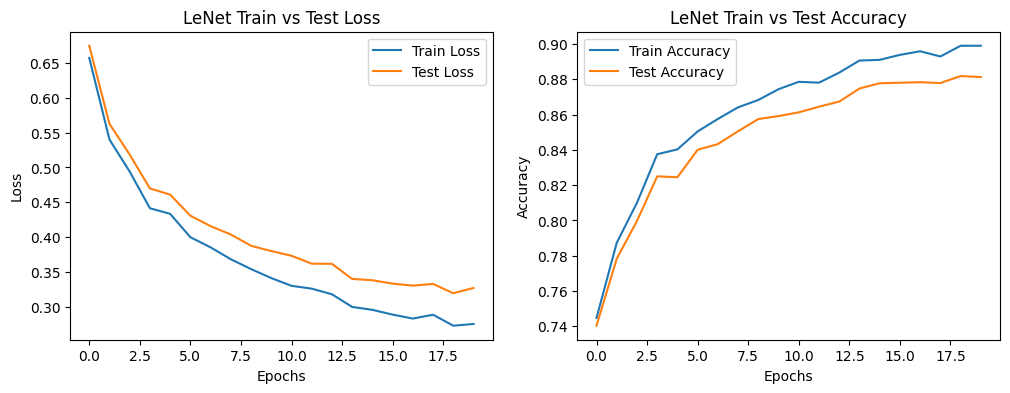

In [ ]:


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(20), LeNet_train_loss, label='Train Loss')
plt.plot(range(20), LeNet_test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LeNet Train vs Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(20), LeNet_train_accuracy, label='Train Accuracy')
plt.plot(range(20), LeNet_test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('LeNet Train vs Test Accuracy')
plt.legend()

plt.show()

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

In terms of parameters, the previous network had total 84,060 trainable parameters and the above LeNet networ model has a total of 61,706 trainable parameters.

In terms of performance, training accuracy is 94.8% and test accuracy is 88.6% for the last epoch of the network from activity 5. Here, the LeNet model has training accuracy of 89.9% and test accuracy of 88.1% in the last epoch of the network.

To bring in the contrast in terms of overfitting, the LeNet network model performs better as the difference bwteen the test acuracy and training accuracy is less, hence it is comparatively less overfitting than the other network from previous activity.

---
# 3. Modernise LeNet
---


Modernise LeNet. What are the preferred activation and pooling functions for modern CNNs?

* Update LeNet with these newer functions.
* Train using the same parameters as above.
* Compare and discuss with the above using the normal discussion criteria


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [ ]:
##############################
# Your code below

class Modernise_LeNet(nn.Module):
    def __init__(self):
        super(Modernise_LeNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


Modernise_LeNet = Modernise_LeNet().to(device)
summary(Modernise_LeNet, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
           Flatten-5                  [-1, 400]               0
            Linear-6                  [-1, 120]          48,120
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


In [ ]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Modernise_LeNet.parameters(), lr=1e-3)
# Note, replace model with the instance name of your model



ModLeNet_train_loss, ModLeNet_train_accuracy, ModLeNet_test_loss, ModLeNet_test_accuracy = train_loop(training_loader, testing_loader, Modernise_LeNet, loss_fn, optimizer, 20)

Epoch 1:

loss: 2.310405  [   64/60000]
loss: 0.737327  [ 6464/60000]
loss: 0.522188  [12864/60000]
loss: 0.577542  [19264/60000]
loss: 0.455935  [25664/60000]
loss: 0.416324  [32064/60000]
loss: 0.538442  [38464/60000]
loss: 0.512174  [44864/60000]
loss: 0.310932  [51264/60000]
loss: 0.591218  [57664/60000]
Train Error: 
 Accuracy: 84.6%, Avg loss: 0.421778 

Test Error: 
 Accuracy: 83.3%, Avg loss: 0.450193 

Epoch 2:

loss: 0.484394  [   64/60000]
loss: 0.298918  [ 6464/60000]
loss: 0.520023  [12864/60000]
loss: 0.312243  [19264/60000]
loss: 0.386187  [25664/60000]
loss: 0.306404  [32064/60000]
loss: 0.389962  [38464/60000]
loss: 0.398918  [44864/60000]
loss: 0.424508  [51264/60000]
loss: 0.380616  [57664/60000]
Train Error: 
 Accuracy: 88.4%, Avg loss: 0.318587 

Test Error: 
 Accuracy: 87.6%, Avg loss: 0.350590 

Epoch 3:

loss: 0.357986  [   64/60000]
loss: 0.369456  [ 6464/60000]
loss: 0.260461  [12864/60000]
loss: 0.214546  [19264/60000]
loss: 0.288082  [25664/60000]
loss: 0.31

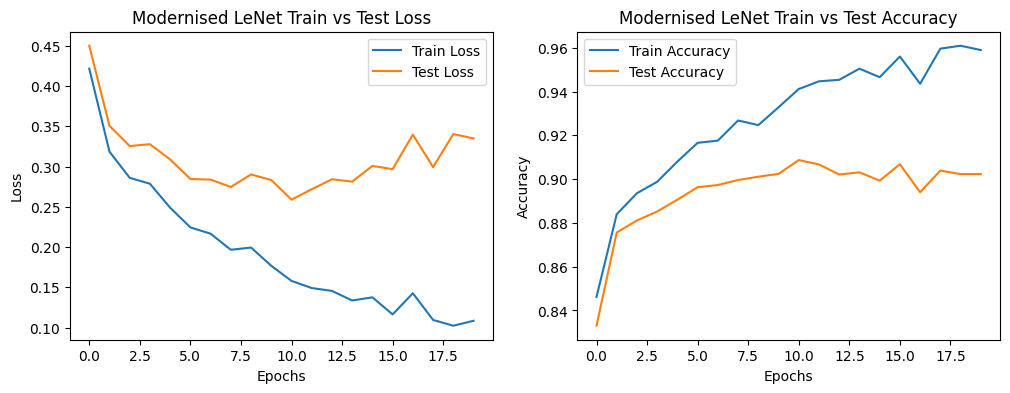

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(20), ModLeNet_train_loss, label='Train Loss')
plt.plot(range(20), ModLeNet_test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Modernised LeNet Train vs Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(20), ModLeNet_train_accuracy, label='Train Accuracy')
plt.plot(range(20), ModLeNet_test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Modernised LeNet Train vs Test Accuracy')
plt.legend()

plt.show()

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

Two changes were made to adapt to the modernised LeNet model.

1. The activation function was changed from sigmoid to ReLu since the new LeNet models use relu as it provides a better solution to the gradient descent problem.

2. The pooling Function was changed from being averaged to max pool.

---
# 4. Build your own CNN model
---

Build your own classifier model - see can you break 90% accuracy. You can use LeNet as a basis if you like.

With some networks I built, I could get 93 to 94% test accuracy.

Some hints:
 * not every convolutional layer needs a pooling layer afterwards
 * Consider adding more layers (maybe more 3x3 layers is better than 1 5x5 layer?)
 * But don't just bung loads of layers in there - you will end up overfitting badly
 * Use a [batchnorm](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739) after each convolutional layer. You get decent performance gains without adding many parameters
 * Don't be afraid to get to a million or two parameters
 * Have a look on Google to see what others are doing (you're going to do this anyway, right?). Don't just copy them, though, try to understand.

Explain what you did that improved things for the classification and why they improved things.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

**1st Setup**

In [ ]:
class ClassifyModel(nn.Module):
    def __init__(self):
        super(ClassifyModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, stride=2)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize and summarize the model
classify_model = ClassifyModel().to(device)
summary(classify_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]              60
       BatchNorm2d-2            [-1, 6, 28, 28]              12
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]             880
       BatchNorm2d-5           [-1, 16, 14, 14]              32
            Conv2d-6           [-1, 32, 14, 14]           4,640
       BatchNorm2d-7           [-1, 32, 14, 14]              64
         MaxPool2d-8             [-1, 32, 7, 7]               0
           Flatten-9                 [-1, 1568]               0
           Linear-10                  [-1, 120]         188,280
          Dropout-11                  [-1, 120]               0
           Linear-12                   [-1, 84]          10,164
           Linear-13                   [-1, 10]             850
Total params: 204,982
Trainable params:

In [ ]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classify_model.parameters(), lr=1e-3)
# Note, replace model with the instance name of your model



New_train_loss, New_train_accuracy, New_test_loss, New_test_accuracy = train_loop(training_loader, testing_loader, classify_model, loss_fn, optimizer, 20)

Epoch 1:

loss: 2.355686  [   64/60000]
loss: 0.781968  [ 6464/60000]
loss: 0.745920  [12864/60000]
loss: 0.937639  [19264/60000]
loss: 0.522215  [25664/60000]
loss: 0.478085  [32064/60000]
loss: 0.504431  [38464/60000]
loss: 0.442936  [44864/60000]
loss: 0.471246  [51264/60000]
loss: 0.377551  [57664/60000]
Train Error: 
 Accuracy: 88.0%, Avg loss: 0.318334 

Test Error: 
 Accuracy: 86.9%, Avg loss: 0.344607 

Epoch 2:

loss: 0.323169  [   64/60000]
loss: 0.322523  [ 6464/60000]
loss: 0.241326  [12864/60000]
loss: 0.565707  [19264/60000]
loss: 0.231387  [25664/60000]
loss: 0.470795  [32064/60000]
loss: 0.364590  [38464/60000]
loss: 0.597642  [44864/60000]
loss: 0.484588  [51264/60000]
loss: 0.462993  [57664/60000]
Train Error: 
 Accuracy: 89.8%, Avg loss: 0.274444 

Test Error: 
 Accuracy: 88.7%, Avg loss: 0.312292 

Epoch 3:

loss: 0.427622  [   64/60000]
loss: 0.337481  [ 6464/60000]
loss: 0.343975  [12864/60000]
loss: 0.215886  [19264/60000]
loss: 0.422854  [25664/60000]
loss: 0.31

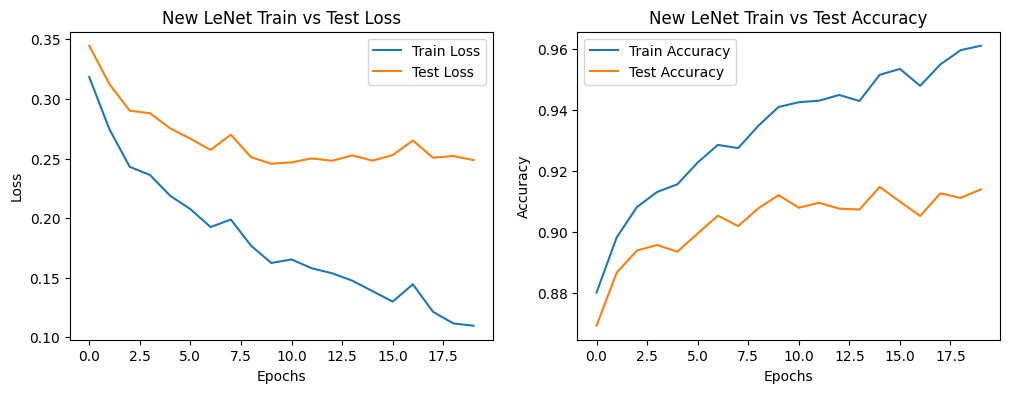

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(20), New_train_loss, label='Train Loss')
plt.plot(range(20), New_test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('New LeNet Train vs Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(20), New_train_accuracy, label='Train Accuracy')
plt.plot(range(20), New_test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('New LeNet Train vs Test Accuracy')
plt.legend()

plt.show()

**2nd Setup**

In [ ]:
class NewClassifyModel(nn.Module):
    def __init__(self):
        super(NewClassifyModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, stride=2)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        # x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize and summarize the model
Newclassify_model = NewClassifyModel().to(device)
summary(Newclassify_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]              60
       BatchNorm2d-2            [-1, 6, 28, 28]              12
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]             880
       BatchNorm2d-5           [-1, 16, 14, 14]              32
            Conv2d-6           [-1, 32, 14, 14]           4,640
       BatchNorm2d-7           [-1, 32, 14, 14]              64
         MaxPool2d-8             [-1, 32, 7, 7]               0
           Flatten-9                 [-1, 1568]               0
           Linear-10                  [-1, 120]         188,280
          Dropout-11                  [-1, 120]               0
           Linear-12                   [-1, 84]          10,164
           Linear-13                   [-1, 10]             850
Total params: 204,982
Trainable params:

In [ ]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Newclassify_model.parameters(), lr=1e-3)
# Note, replace model with the instance name of your model

In [ ]:
Newtrain_loss, Newtrain_accuracy, Newtest_loss, Newtest_accuracy = train_loop(training_loader, testing_loader, Newclassify_model, loss_fn, optimizer, 20)

Epoch 1:

loss: 2.305403  [   64/60000]
loss: 0.519819  [ 6464/60000]
loss: 0.748896  [12864/60000]
loss: 0.436920  [19264/60000]
loss: 0.477641  [25664/60000]
loss: 0.350731  [32064/60000]
loss: 0.369539  [38464/60000]
loss: 0.401171  [44864/60000]
loss: 0.347061  [51264/60000]
loss: 0.341441  [57664/60000]
Train Error: 
 Accuracy: 88.7%, Avg loss: 0.305549 

Test Error: 
 Accuracy: 87.4%, Avg loss: 0.343093 

Epoch 2:

loss: 0.394627  [   64/60000]
loss: 0.242353  [ 6464/60000]
loss: 0.222747  [12864/60000]
loss: 0.385129  [19264/60000]
loss: 0.372764  [25664/60000]
loss: 0.214125  [32064/60000]
loss: 0.427765  [38464/60000]
loss: 0.236382  [44864/60000]
loss: 0.315672  [51264/60000]
loss: 0.273313  [57664/60000]
Train Error: 
 Accuracy: 91.2%, Avg loss: 0.235194 

Test Error: 
 Accuracy: 89.4%, Avg loss: 0.279816 

Epoch 3:

loss: 0.176603  [   64/60000]
loss: 0.328144  [ 6464/60000]
loss: 0.265848  [12864/60000]
loss: 0.215905  [19264/60000]
loss: 0.248383  [25664/60000]
loss: 0.33

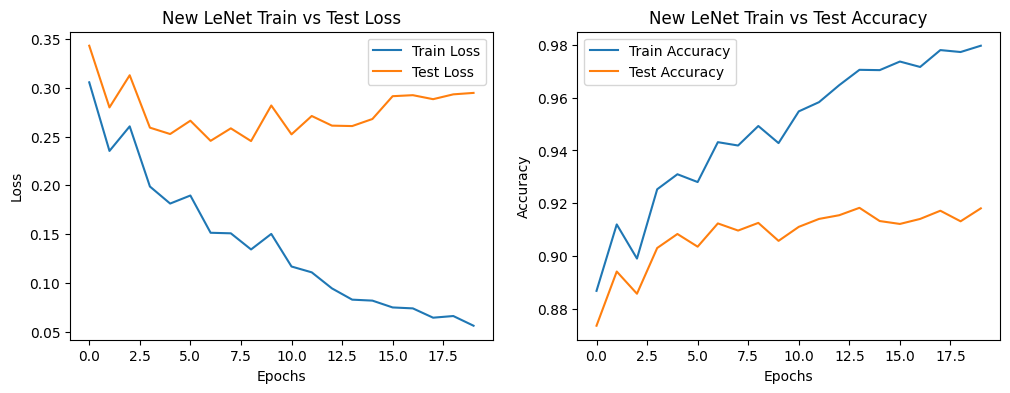

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(20), Newtrain_loss, label='Train Loss')
plt.plot(range(20), Newtest_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('New LeNet Train vs Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(20), Newtrain_accuracy, label='Train Accuracy')
plt.plot(range(20), Newtest_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('New LeNet Train vs Test Accuracy')
plt.legend()

plt.show()

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

Setup1: Added a new convolutional layer and batchnorm to generalize the model, also changed the kernel size to 3 which helped me achieve 91.4 %


Setup2:  However is setup 2, reducing the dropout rate to 0.3 % helped me achieve a better result by 0.4% than the previous setup.

---
# 5. Transfer Learning
---

Nobody trains large models from scratch. Rather, they use large pretrained models, that have been trained perhaps for weeks on very large datasets. Then, we can tweak the model for our needs. This allows us to use large models on small datasets and (hopefully) avoid some overfitting.

We are going to load ResNet18, we're going to cut the head off it - in this case, we will replace the very last layer. ResNet18 was trained for 1000 classes, we only have 10.

Do the following:
1. From `torchvision.models`, load [`ResNet18`](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html), and use random weights (`weights=None`). Replace the full-connected layer at the end with your own fully connect layer. Train and plot the loss and accuracy.
1. Repeat step 1, but use the default paramaters, and retrain. In this case, the default parameters.
1. Freeze all but the last layer of your adapted ResNet model, and retrain.
1. Provide some commentary on the three approaches. Particularly, what's the difference between all three approaches we outlined here?

For the freezing of layers, the following article is useful:
https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6

In step 3 above, we may see that the network doesn't necessarily perform as well as previous networks, in terms of test accuracy. Probably we should unfreeze more of the later layers to allow better fine-tuning of the network to our problem. And there are more complicated and powerful finetuning strategies out there. But you should see that overfitting is, more or less, solved. This is because we are only training a much smaller number of parameters, and freezing all of the convolution layers in the ResNet.


In [11]:
# We need to recreate the dataloaders, because ResNet expects a three channel
# RGB input, whereas FashionMNIST only has 1 channel (greyscale). Use
# `transforms.Grayscale(3)` to replicated the grayscale image into the three
# channels.

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.2859, std = 0.3530),
    ])
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.2859, std = 0.3530),
    ])
)

batch_size = 64
# Recreate the data loaders.
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

**1.Random weights**

In [12]:
##############################
# Your code below

resnet18 = torchvision.models.resnet18(weights=None).to(device)
summary(resnet18, (3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
       BasicBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

In [ ]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=1e-3)
# Note, replace model with the instance name of your model

##############################
# Your code below
resnet18.fc

resnet18.fc = nn.Linear(512,10)

Epoch 1:

loss: 0.301261  [   64/60000]
loss: 0.452791  [ 6464/60000]
loss: 0.274666  [12864/60000]
loss: 0.412208  [19264/60000]
loss: 0.375272  [25664/60000]
loss: 0.377340  [32064/60000]
loss: 0.274180  [38464/60000]
loss: 0.528266  [44864/60000]
loss: 0.312777  [51264/60000]
loss: 0.331918  [57664/60000]
Train Error: 
 Accuracy: 85.4%, Avg loss: 0.375856 

Test Error: 
 Accuracy: 83.9%, Avg loss: 0.417986 

Epoch 2:

loss: 0.271760  [   64/60000]
loss: 0.307390  [ 6464/60000]
loss: 0.225486  [12864/60000]
loss: 0.317629  [19264/60000]
loss: 0.253875  [25664/60000]
loss: 0.370964  [32064/60000]
loss: 0.257929  [38464/60000]
loss: 0.382017  [44864/60000]
loss: 0.248240  [51264/60000]
loss: 0.328966  [57664/60000]
Train Error: 
 Accuracy: 89.2%, Avg loss: 0.282201 

Test Error: 
 Accuracy: 87.5%, Avg loss: 0.331773 

Epoch 3:

loss: 0.222003  [   64/60000]
loss: 0.209438  [ 6464/60000]
loss: 0.202188  [12864/60000]
loss: 0.247285  [19264/60000]
loss: 0.224395  [25664/60000]
loss: 0.32

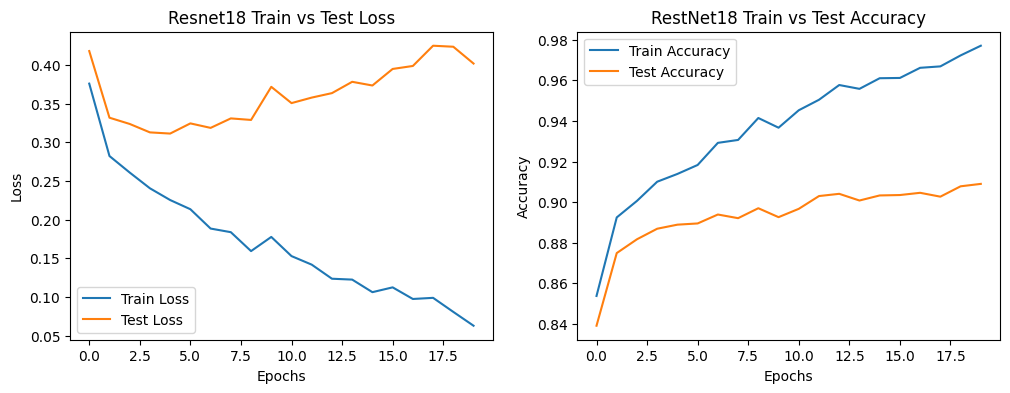

In [ ]:
##############################
# Your code below

resnet18_train_loss, resnet18_train_accuracy, resnet18_test_loss, resnet18_test_accuracy = train_loop(train_dataloader, test_dataloader, resnet18.to(device), loss_fn, optimizer, 20)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(20), resnet18_train_loss, label='Train Loss')
plt.plot(range(20), resnet18_test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Resnet18 Train vs Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(20), resnet18_train_accuracy, label='Train Accuracy')
plt.plot(range(20), resnet18_test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('RestNet18 Train vs Test Accuracy')
plt.legend()

plt.show()

**2. Resnet with weights**

Epoch 1:

loss: 2.595011  [   64/60000]
loss: 0.371305  [ 6464/60000]
loss: 0.410145  [12864/60000]
loss: 0.404284  [19264/60000]
loss: 0.563277  [25664/60000]
loss: 0.408371  [32064/60000]
loss: 0.284133  [38464/60000]
loss: 0.447665  [44864/60000]
loss: 0.264481  [51264/60000]
loss: 0.334012  [57664/60000]
Train Error: 
 Accuracy: 88.1%, Avg loss: 0.320890 

Test Error: 
 Accuracy: 86.9%, Avg loss: 0.355643 

Epoch 2:

loss: 0.275488  [   64/60000]
loss: 0.286318  [ 6464/60000]
loss: 0.218681  [12864/60000]
loss: 0.232702  [19264/60000]
loss: 0.295818  [25664/60000]
loss: 0.435197  [32064/60000]
loss: 0.248431  [38464/60000]
loss: 0.331394  [44864/60000]
loss: 0.227717  [51264/60000]
loss: 0.201578  [57664/60000]
Train Error: 
 Accuracy: 90.8%, Avg loss: 0.249512 

Test Error: 
 Accuracy: 89.4%, Avg loss: 0.294277 

Epoch 3:

loss: 0.199492  [   64/60000]
loss: 0.225747  [ 6464/60000]
loss: 0.166496  [12864/60000]
loss: 0.171498  [19264/60000]
loss: 0.222828  [25664/60000]
loss: 0.34

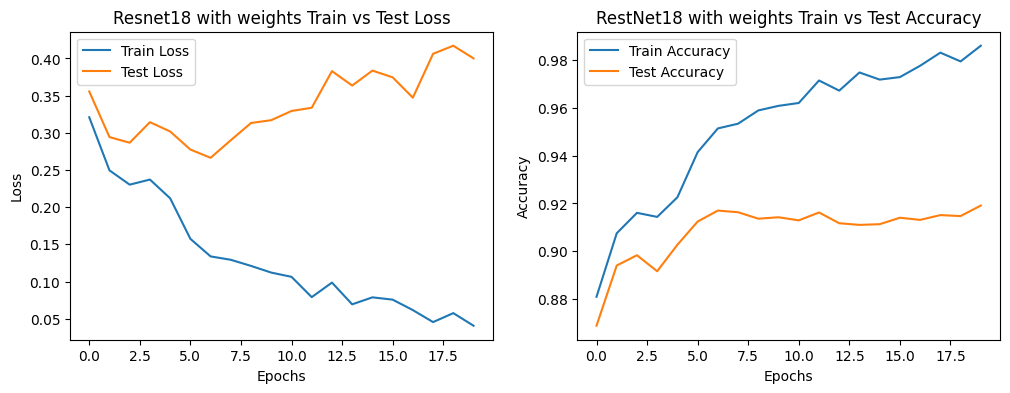

In [14]:
# Define the loss function and the optimizer

resnet18 = torchvision.models.resnet18(weights='IMAGENET1K_V1')
resnet18.fc = nn.Linear(512, 10)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=1e-3)

resnet18_train_loss, resnet18_train_accuracy, resnet18_test_loss, resnet18_test_accuracy = train_loop(train_dataloader, test_dataloader, resnet18.to(device), loss_fn, optimizer, 20)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(20), resnet18_train_loss, label='Train Loss')
plt.plot(range(20), resnet18_test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Resnet18 with weights Train vs Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(20), resnet18_train_accuracy, label='Train Accuracy')
plt.plot(range(20), resnet18_test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('RestNet18 with weights Train vs Test Accuracy')
plt.legend()

plt.show()

**3.Freezing all except last but one layer**

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2.bias False
layer2.0.downsample.0.weight False
layer2.0.downsample.1.weight False
layer2.0.downsample.1.bias False
layer2.1.conv1.weight False
layer2.1.bn1.weight False
layer2.1.bn1.bias False
layer2.1.conv2.weight False
layer2.1.bn2.weight False
layer2.1.bn2.bias False
layer3.0.conv1.weight False
layer3.0.bn1.weight False
layer3.0.bn1.bias False
layer3.0.conv2.weight False
layer3.0.bn2.weight False
layer3.0.bn2.bias False
layer3.0.downsample.0.weight False
layer3.0.downsample.1.weight Fa

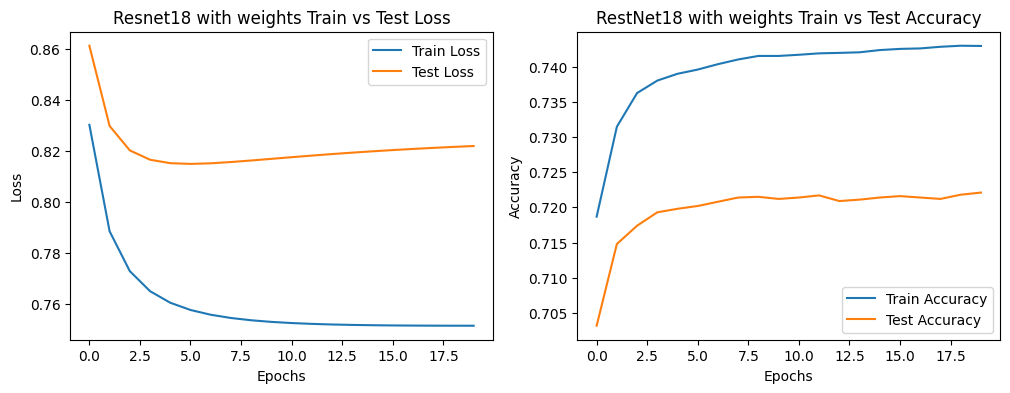

In [15]:
# Define the loss function and the optimizer
resnet18 = torchvision.models.resnet18(weights='IMAGENET1K_V1')
resnet18.fc = nn.Linear(512, 10)

for name, param in resnet18.named_parameters():
  param.requires_grad = True
  if name == "fc.weight" or name == "fc.bias":
    param.requires_grad = True
  else:
    param.requires_grad = False

  print(name, param.requires_grad)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=1e-3)

resnet18_train_loss, resnet18_train_accuracy, resnet18_test_loss, resnet18_test_accuracy = train_loop(train_dataloader, test_dataloader, resnet18.to(device), loss_fn, optimizer, 20)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(20), resnet18_train_loss, label='Train Loss')
plt.plot(range(20), resnet18_test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Resnet18 with weights Train vs Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(20), resnet18_train_accuracy, label='Train Accuracy')
plt.plot(range(20), resnet18_test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('RestNet18 with weights Train vs Test Accuracy')
plt.legend()

plt.show()


### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

1. The first approach trains on Resnet architecture but on the mnsit data while keeping the weight random and not using the weights of the resnet architecture.

2. The second approach makes use of the resnet archtiecture's pre-trained weights and trains the model similar to the first approach.

3. The third approach is a follow up of the second approach but we freeze all the layers except the last one and this updates the weight of the final layer only. The accuracy has dropped however, the execution was faster.